We will be able to :

- Predict stock prices using ARIMA 


## Dataset description

In this Dataset, we see stocks and ETFs (Exchange trade funding) data for USA. 
The columns of the data are:
1. Date
2. Open
3. High
4. Low
5. Close
6. volume
7. OpenInt


[Dataset link]( https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs)


The files present are named according to Stock listing


A ticker symbol or stock symbol is an abbreviation used to uniquely identify publicly traded shares of a particular stock on a particular stock market. A stock symbol may consist of letters, numbers or a combination of both. "Ticker symbol" refers to the symbols that were printed on the ticker tape of a ticker tape machine.

To understand better go through : https://www.nasdaq.com/market-activity/stocks/screener

###  Domain Information
Stock price forecasting is one of the most challenging tasks in financial decision-making because stock prices are inherently noisy and non-stationary and have been observed to have a random-walk characteristic. Accurate stock price predictions can yield significant profits and therefore econometric and statistical approaches including linear/non-linear methods such as autoregressive (AR) models, moving averages (MA), autoregressive moving averages (ARIMA) and artificial neural networks have been in use. 

## ARIMA

Autoregressive Integrated Moving Average Model (ARIMA)
is a generalized model of Autoregressive Moving Average (ARMA) that combines
Autoregressive (AR) process and Moving Average (MA) processes and builds a composite model of the time series.
As the acronym indicates, ARIMA (p, d,q) captures the key elements of the model:
- AR: Autoregression. A regression model that uses the dependencies between an observation and a number of
lagged observations (p).
- I: Integrated. To make the time series stationary by measuring the differences of observations at different time
(d).
- MA: Moving Average. An approach that takes into accounts the dependency between observations and the
residual error terms when a moving average model is used to the lagged observations (q). 


In [ ]:
!unzip price-volume-data-for-all-us-stocks-etfs.zip

In [ ]:
# Import Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
warnings.filterwarnings('ignore')


## Google Stock Market Analysis using ARIMA


Read the Google stock prices data file

In [ ]:
# You can change the file to predict stocks for different companies
# Open, High, Low, Close values are in dollars. 
# Volume refers to the number of contracts traded in a given period, 
# Open interest denotes the number of contracts that are open or active.

df = pd.read_csv("/content/Data/Stocks/googl.us.txt")
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2004-08-19,50.000,52.03,47.980,50.170,44703800,0
1,2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2,2004-08-23,55.375,56.74,54.525,54.700,18274400,0
3,2004-08-24,55.620,55.80,51.785,52.435,15262600,0
4,2004-08-25,52.480,54.00,51.940,53.000,9197800,0


In [ ]:
print(df.head())
print(df.shape)
print(df.columns)

         Date    Open   High     Low   Close    Volume  OpenInt
0  2004-08-19  50.000  52.03  47.980  50.170  44703800        0
1  2004-08-20  50.505  54.54  50.250  54.155  22857200        0
2  2004-08-23  55.375  56.74  54.525  54.700  18274400        0
3  2004-08-24  55.620  55.80  51.785  52.435  15262600        0
4  2004-08-25  52.480  54.00  51.940  53.000   9197800        0
(3333, 7)
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt'], dtype='object')


No handles with labels found to put in legend.


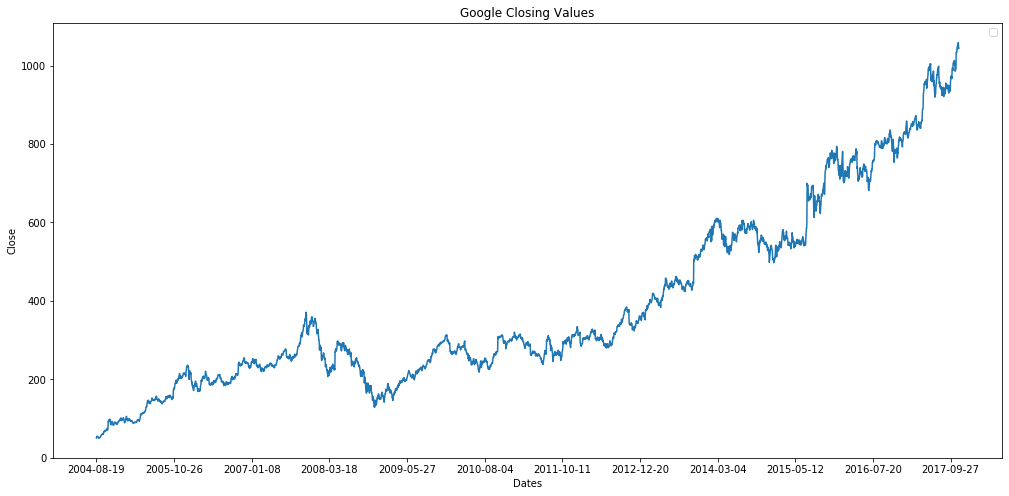

In [ ]:
# Plot the closing values for Google
plt.figure(figsize=(17,8))
plt.plot(df['Close'])
plt.title('Google Closing Values')
plt.xlabel('Dates')
plt.ylabel('Close')
plt.xticks(np.arange(0,3332, 300), df['Date'][0:3332:300])
plt.legend()

                                                Date  ... OpenInt
0                                         2004-08-19  ...       0
1                               2004-08-192004-08-20  ...       0
2                     2004-08-192004-08-202004-08-23  ...       0
3           2004-08-192004-08-202004-08-232004-08-24  ...       0
4  2004-08-192004-08-202004-08-232004-08-242004-0...  ...       0

[5 rows x 7 columns]


Text(0.5, 1.0, 'Google Cumulative Returns')

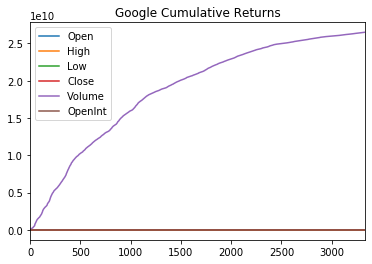

In [ ]:
# Return the cumulative sum of the dataframe
dr = df.cumsum()
print(dr[:5])
dr.plot()
plt.title('Google Cumulative Returns')

Text(0.5, 1.0, 'Google Autocorrelation plot')

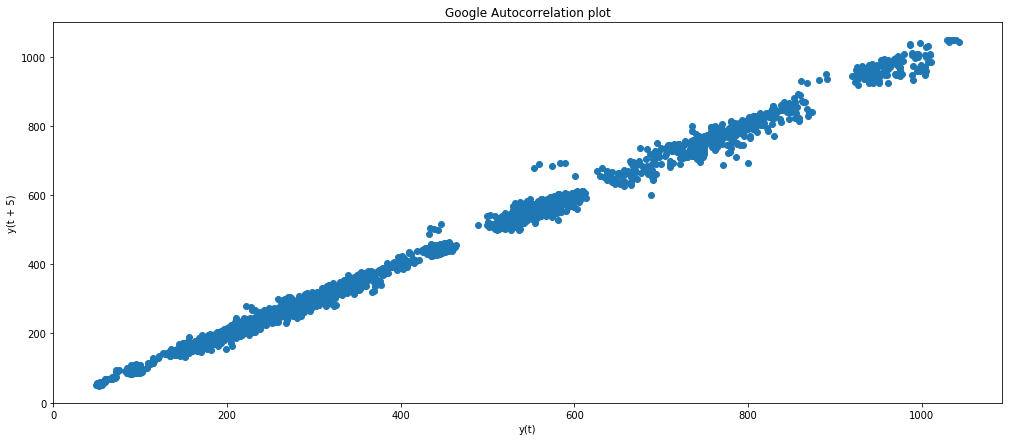

In [ ]:
# Find the autocorrelation using lag plot. 
# A lag plot checks whether a data set or time series is random or not.
# Non-random data exhibits an identifiable structure in the lag plot (eg. linear structure).
plt.figure(figsize=(17,7))
lag_plot(df['Open'], lag=5)
plt.title('Google Autocorrelation plot')

The above graph exhibits a linear pattern indicating that the data are non-random and suggests that an autoregressive model will be appropriate for this data.

In [ ]:
# Find out the last date given in Google data
df['Date'][::-1]


3332    2017-11-10
3331    2017-11-09
3330    2017-11-08
3329    2017-11-07
3328    2017-11-06
           ...    
4       2004-08-25
3       2004-08-24
2       2004-08-23
1       2004-08-20
0       2004-08-19
Name: Date, Length: 3333, dtype: object

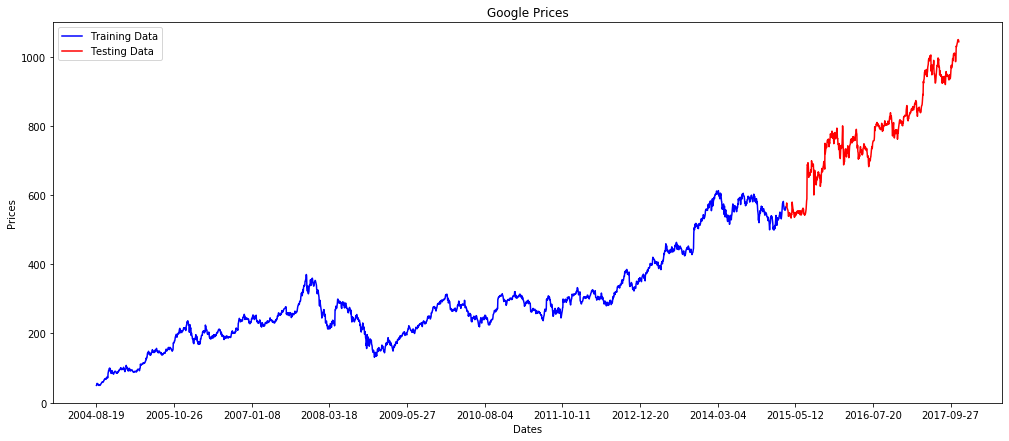

In [ ]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):] # Train and test split
plt.figure(figsize=(17,7))
plt.title('Google Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data['Open'], 'blue', label='Training Data') #Plot train data in blue color
plt.plot(test_data['Open'], 'red', label='Testing Data')  # Plot test data in red color
plt.xticks(np.arange(0,3332, 300), df['Date'][0:3332:300])
plt.legend()

In [ ]:
# Function to Calculate the mean absolute percentage error
# The mean absolute percentage error (MAPE) is a statistical measure of how accurate a forecast system is.
# It measures this accuracy as a percentage, and can be calculated as the average absolute percent error for each time 
# period minus actual values divided by actual values
def  Mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

**ARIMA model**

In [ ]:
# ARIMA model
train_ar = train_data['Open'].values
test_ar = test_data['Open'].values

history = [x for x in train_ar]
print(type(history))

predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))   
    # (5, 1, 0) indicates a lag value of 5 for autoregression, a difference order of 1 to make the time series stationary and a moving average model of 0. 
    model_fit = model.fit(disp=0)     
    # Above, disp=0 setting turns off the large amount of debug information provided regarding the fit of the regression model.
    output = model_fit.forecast() # one-step forecast
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

error = Mean_absolute_percentage_error(test_ar, predictions)
print('Mean absolute percentage error: %.3f' % error)

<class 'list'>
Mean absolute percentage error: 19.309


## Here we plot our predictions

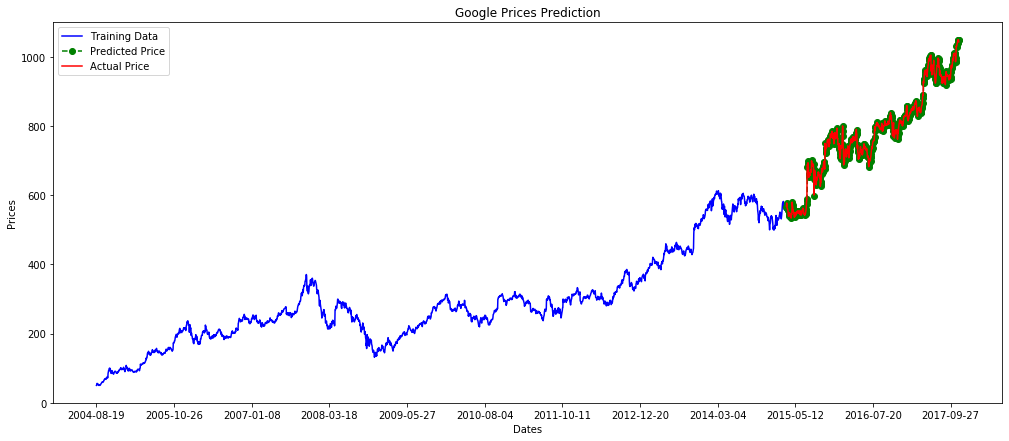

In [ ]:
# Plot the predictions
plt.figure(figsize=(17,7))
plt.plot(train_data['Open'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green',marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red', label='Actual Price')
plt.title('Google Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,3332, 300), df['Date'][0:3332:300])
plt.legend()

## Lets Compare Predicted and Actual visually

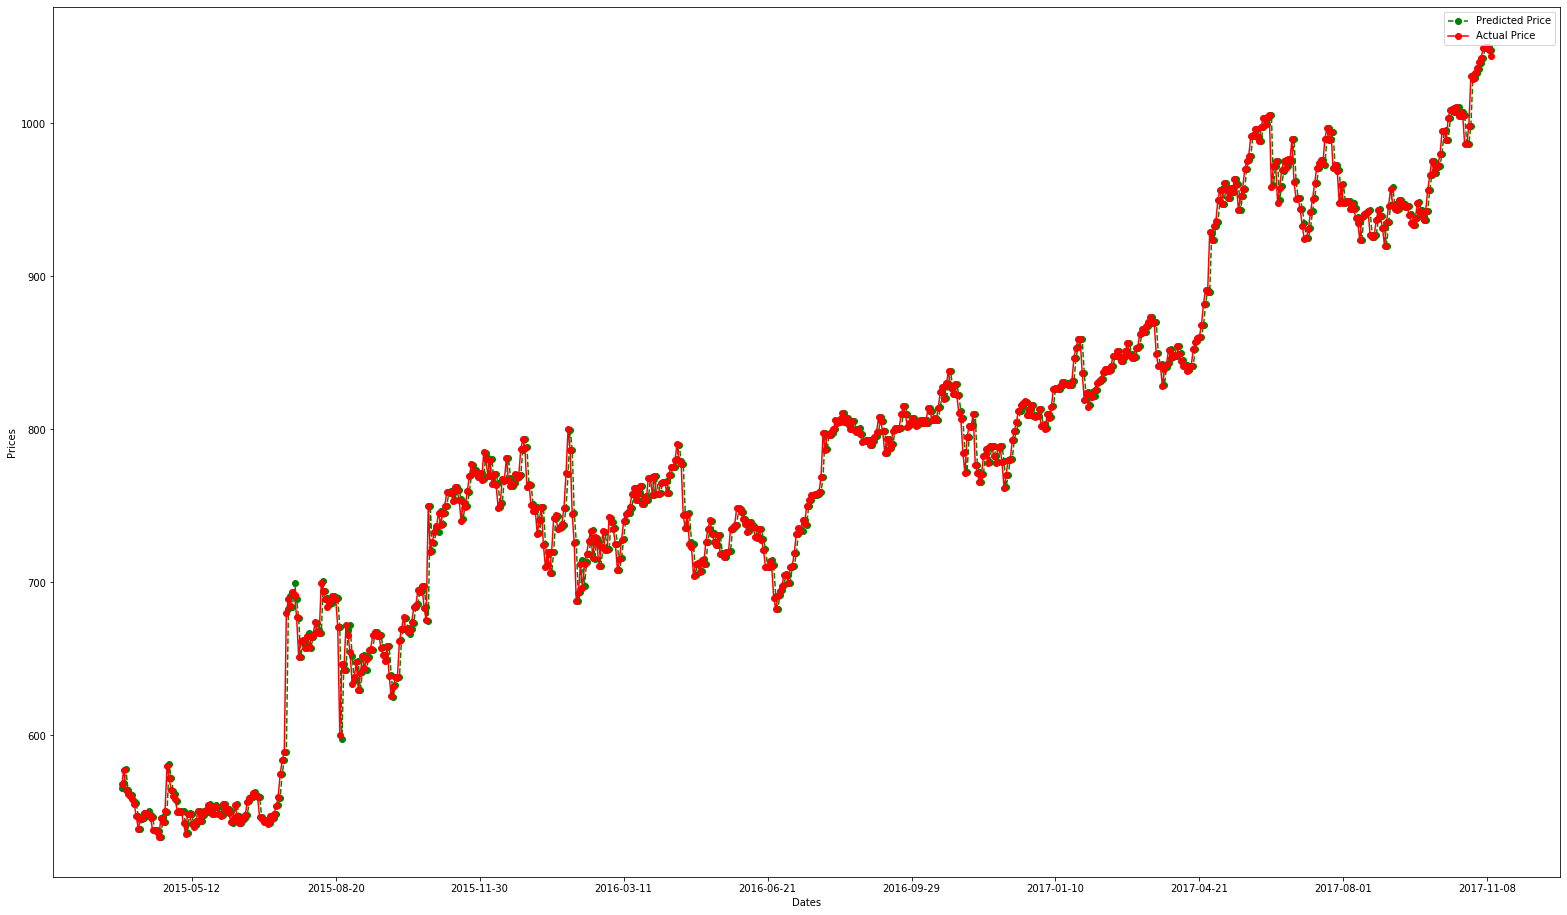

In [ ]:
plt.figure(figsize=(27,16))
#ax3 = plt.subplot(222)
plt.plot(test_data.index, predictions, color='green',marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Open'], color='red',marker='o', label='Actual Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(2700,3332, 70), df['Date'][2700:3332:70])
plt.legend()